In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib
import pickle

from f1_data_loader import load_race_data
from preprare_inputs import prepare_inputs_infer

In [29]:
YEAR = 2025
RACE_NAME = "Monaco Grand Prix"
DRIVER = "BEA"   # <- change this to any driver
WINDOW = 6

/home/eatlunches/miniconda3/envs/deeplearning/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 44 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/eatlunches/miniconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



=== Sanity Check: Monaco Grand Prix – BEA ===
Loading cached race: Monaco Grand Prix

Cleaned laps:
   LapNumber  Stint  lap_time
0        4.0      2    82.127
1        5.0      2    75.576
2        6.0      2    74.855
3        8.0      2    78.303
4        9.0      2    76.467

X_num shape: (58, 6, 8)
indices length: 58
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 825ms/step
Pred shape: (58,), True shape: (58,)


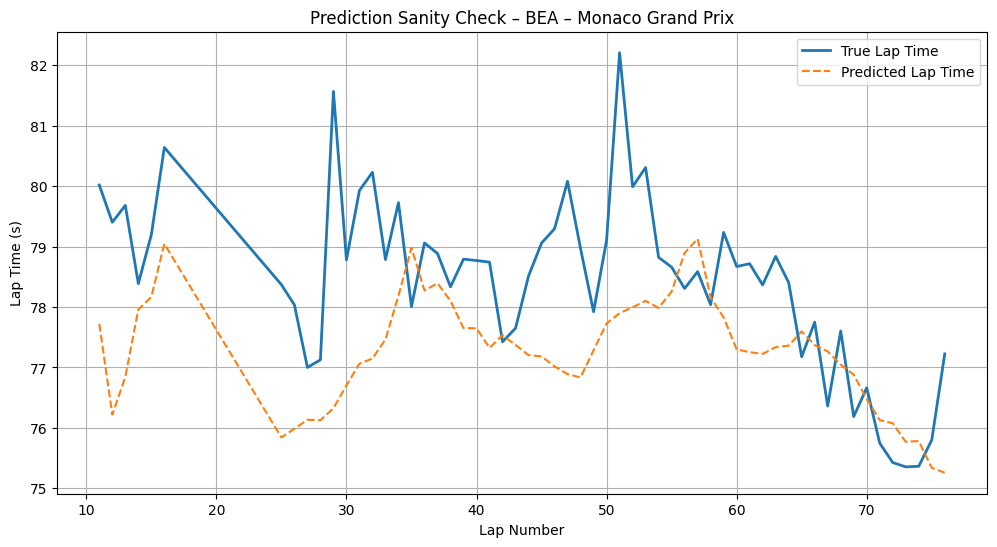

In [30]:
def main():

    # Load model + scalers + vocab
    model = tf.keras.models.load_model("static/model/F1_laptime_model.keras")
    x_scaler = joblib.load("static/model/X_scaler.pkl")
    y_scaler = joblib.load("static/model/y_scaler.pkl")
    with open("static/model/id_mappings.pkl", "rb") as f:
        vocab = pickle.load(f)

    print(f"\n=== Sanity Check: {RACE_NAME} – {DRIVER} ===")

    # Load race
    df_race = load_race_data(YEAR, RACE_NAME)
    df_driver = df_race[df_race["Driver"] == DRIVER].sort_values("LapNumber")

    # Filter
    df_driver["Stint"] = df_driver["Stint"].astype(int)
    df_clean = df_driver[
        (df_driver["pit_flag"] == 0) &
        (df_driver["yellow_flag"] == 0) &
        (df_driver["sc_flag"] == 0) &
        (df_driver["vsc_flag"] == 0)
    ]
    df_clean = df_clean[df_clean["lap_time"] < df_clean["lap_time"].quantile(0.99)]
    df_clean = df_clean[(df_clean["lap_time"] > 40) & (df_clean["lap_time"] < 110)]
    df_clean = df_clean.reset_index(drop=True)

    print("\nCleaned laps:")
    print(df_clean[["LapNumber", "Stint", "lap_time"]].head())

    # Prepare inputs
    X_num, Xd, Xt, indices = prepare_inputs_infer(df_clean, x_scaler, vocab)
    print(f"\nX_num shape: {X_num.shape}")
    print(f"indices length: {len(indices)}")

    # Predict
    y_pred_scaled = model.predict({
        "num_input": X_num,
        "driver_input": Xd,
        "team_input": Xt
    }).flatten()

    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # True values
    y_true = df_clean.loc[indices, "lap_time"].values
    laps = df_clean.loc[indices, "LapNumber"].values

    print(f"Pred shape: {y_pred.shape}, True shape: {y_true.shape}")

    # -------------------------------
    # PLOT
    # -------------------------------
    plt.figure(figsize=(12, 6))
    plt.plot(laps, y_true, label="True Lap Time", linewidth=2)
    plt.plot(laps, y_pred, label="Predicted Lap Time", linestyle="--")
    plt.xlabel("Lap Number")
    plt.ylabel("Lap Time (s)")
    plt.title(f"Prediction Sanity Check – {DRIVER} – {RACE_NAME}")
    plt.legend()
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    main()